In [1]:
import os
import contextlib
from pathlib import Path


import pandas as pnd
import cobra
import memote
import seaborn as sb


from helper_functions import *

# define main functions

In [2]:
def extract_memote_metrics(memote_report): 


    test_results = dict(memote_report[1])['tests']

    sections = {
        'consistency': [
            ('test_stoichiometric_consistency', 3),
            ('test_reaction_mass_balance', 1),
            ('test_reaction_charge_balance', 1),
            ('test_find_disconnected', 1),
            ('test_find_reactions_unbounded_flux_default_condition', 1)
        ],

        'annotation_M': [
            ('test_metabolite_annotation_presence', 1),
            ('test_metabolite_annotation_overview', 1),
            ('test_metabolite_annotation_wrong_ids', 1),
            ('test_metabolite_id_namespace_consistency', 1),
        ],

        'annotation_R': [
            ('test_reaction_annotation_presence', 1),
            ('test_reaction_annotation_overview', 1),
            ('test_reaction_annotation_wrong_ids', 1),
            ('test_reaction_id_namespace_consistency', 1),
        ],

        'annotation_G': [
            ('test_gene_product_annotation_presence', 1),
            ('test_gene_product_annotation_overview', 1),
            ('test_gene_product_annotation_wrong_ids', 1),
        ],

        'annotation_SBO': [
            ('test_metabolite_sbo_presence', 1),
            ('test_metabolite_specific_sbo_presence', 1),
            ('test_reaction_sbo_presence', 1),
            ('test_metabolic_reaction_specific_sbo_presence', 1),
            ('test_transport_reaction_specific_sbo_presence', 1),
            ('test_exchange_specific_sbo_presence', 1),
            ('test_demand_specific_sbo_presence', 1),
            ('test_sink_specific_sbo_presence', 1),
            ('test_gene_sbo_presence', 1),
            ('test_gene_specific_sbo_presence', 1),
            ('test_biomass_specific_sbo_presence', 1),
        ],
    }
    section_multipliers = {
        'consistency': 3,
        'annotation_M': 1,
        'annotation_R': 1,
        'annotation_G': 1,
        'annotation_SBO': 2,
    }
    
    results = {}
    
    numerator_total = 0
    denominator_total = 0
    
    
    invert_charge = False  # flag. 
    # If all metabolites in a model are without formula and charge,
    # then mass_balance will be presented as 0% and charge balance as 100% in the html report.
    
    
    for section , metrics in sections.items(): 
        numerator = 0
        denominator = 0
        
        for metric, multiplier in metrics:
            metric_raw = test_results[metric]['metric']

            if type(metric_raw) == float: 
                metric_percentage = ((1- metric_raw ) *100)
                
                if metric=='test_reaction_mass_balance' and metric_percentage == 0:
                    invert_charge = True
                    
                if metric=='test_reaction_charge_balance' and invert_charge:
                    metric_percentage = 100 - metric_percentage
                
                denominator = denominator + multiplier
                numerator = numerator + (metric_percentage * multiplier)
                
                         
            else: 
                for key, value in metric_raw.items():

                    n_subcategories = len(metric_raw)
                    multiplier_corrected = multiplier / n_subcategories

                    metric_percentage = ((1- value ) *100)
                    denominator = denominator + multiplier_corrected
                    numerator = numerator + (metric_percentage * multiplier_corrected)

                    
        sub_total = numerator / denominator
        results[section] = sub_total
        
        
        denominator_total = denominator_total + section_multipliers[section] *denominator
        numerator_total = numerator_total + section_multipliers[section] *numerator 
        results['total'] = numerator_total/ denominator_total
        
        
    return results

In [3]:
def get_memote_results_df(files):
    
    
    results_df = [] 
    for file in files:
    
        strain_id = Path(file).stem
        if '-draft' in strain_id: 
            continue    # Skip gapseq draft models

        if file.endswith('.xml'): 
            model = cobra.io.read_sbml_model(file)
        if file.endswith('.json'): 
            model = cobra.io.load_json_model(file)


        # launch memote
        with open(os.devnull, 'w') as devnull:
            with contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
                # explicit just the 5 tests that we need:
                try: memote_report = memote.suite.api.test_model(model, exclusive=[
                    'test_annotation', 'test_sbo',
                    #'test_consistency',
                    'test_stoichiometric_consistency',
                    'test_reaction_mass_balance',
                    'test_reaction_charge_balance',
                    'test_find_disconnected',
                    'test_find_reactions_unbounded_flux_default_condition'], results=True)
                except ValueError: memote_report = None


        memote_results_dict = extract_memote_metrics(memote_report)

        results_df.append({'strain': strain_id, 'metric': 'consistency', 'value': memote_results_dict['consistency']})
        results_df.append({'strain': strain_id, 'metric': 'annotation_M', 'value': memote_results_dict['annotation_M']})
        results_df.append({'strain': strain_id, 'metric': 'annotation_R', 'value': memote_results_dict['annotation_R']})
        results_df.append({'strain': strain_id, 'metric': 'annotation_G', 'value': memote_results_dict['annotation_G']})
        results_df.append({'strain': strain_id, 'metric': 'annotation_SBO', 'value': memote_results_dict['annotation_SBO']})
        results_df.append({'strain': strain_id, 'metric': 'total', 'value': memote_results_dict['total']})
        
        print('▯', end='')  # loading bar

    results_df = pnd.DataFrame.from_records(results_df)
    return results_df

# main run

In [4]:
%%capture --no-stdout


for dataset in ['01_klebsiella', '02_ralstonia', '03_pseudomonas']:
    
    df_list = []
    for tool in ['reference', 'gempipe', 'gempipe_rf', 'carveme', 'gapseq', 'bactabolize']:
        
        if tool=='reference' and dataset=='01_klebsiella': 
            globber = '01_klebsiella/reference/iYL1228_edited.xml'
        if tool=='reference' and dataset=='02_ralstonia': 
            globber = '02_ralstonia/reference/iRP1476_edited.xml'
        if tool=='reference' and dataset=='03_pseudomonas': 
            globber = '03_pseudomonas/reference/iJN1463_edited.xml'
            
        if tool == 'gempipe': 
            globber = f'{dataset}/tools_runs/gempipe/output/strain_models_gf/*.json'
        if tool == 'gempipe_rf': 
            globber = f'{dataset}/tools_runs/gempipe_rf/output/strain_models_gf/*.json'
        if tool == 'carveme': 
            globber = f'{dataset}/tools_runs/carveme/output/*.xml'
        if tool == 'bactabolize': 
            globber = f'{dataset}/tools_runs/bactabolize/gapfilled/*.json'
        if tool == 'gapseq': 
            globber = f'{dataset}/tools_runs/gapseq/output/*/*.xml'
        
        
        print(dataset, tool, end=': ') 
        res = parallelizer(globber, get_memote_results_df, nthreads=37)
        print()
        
        res['tool'] = tool
        res['dataset'] = dataset
        df_list.append(res)
        
    df_dataset = pnd.concat(df_list)
    df_dataset.to_csv(f'{dataset}/tables/memote.csv')
    

01_klebsiella reference: ▯
01_klebsiella gempipe: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
01_klebsiella gempipe_rf: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
01_klebsiella carveme: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
01_klebsiella gapseq: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
01_klebsiella bactabolize: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
02_ralstonia reference: ▯
02_ralstonia gempipe: ▯▯▯▯▯▯▯▯▯▯▯
02_ralstonia gempipe_rf: ▯▯▯▯▯▯▯▯▯▯▯
02_ralstonia carveme: ▯▯▯▯▯▯▯▯▯▯▯
02_ralstonia gapseq: ▯▯▯▯▯▯▯▯▯▯▯
02_ralstonia bactabolize: ▯▯▯▯▯▯▯▯▯▯▯
03_pseudomonas reference: ▯
03_pseudomonas gempipe: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
03_pseudomonas gempipe_rf: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
03_pseudomonas carveme: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
03_pseudomonas gapseq: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
03_pseudomonas bactabolize: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯


# memote plot

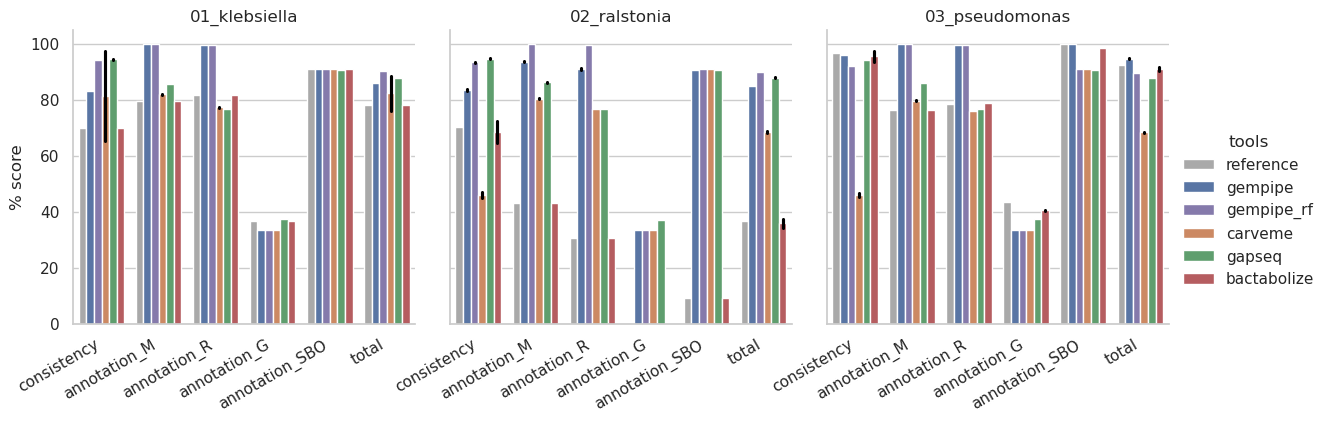

In [5]:
memote_01 = pnd.read_csv(f'01_klebsiella/tables/memote.csv', index_col=0)
memote_02 = pnd.read_csv(f'02_ralstonia/tables/memote.csv', index_col=0)
memote_03 = pnd.read_csv(f'03_pseudomonas/tables/memote.csv', index_col=0)
memote_all = pnd.concat([memote_01, memote_02, memote_03])


sb.set_theme(style="whitegrid")
palette = {
    'reference': 'darkgrey', 
    'gempipe': 'C0', 'gempipe_rf': 'C4', 'carveme': 'C1', 'gapseq': 'C2', 'bactabolize': 'C3'}
g = sb.FacetGrid(memote_all, col="dataset", height=4)
g = g.map_dataframe(
    sb.barplot, x='metric', y='value', hue='tool', palette=palette, 
    edgecolor='white', errorbar='sd', err_kws={'color': 'black'})
g = g.add_legend(title='tools')
g.set_axis_labels('', '% score')
g.set_xticklabels(rotation=30, ha='right')
axes = g.axes.flatten()
axes[0].set_title("01_klebsiella")
axes[1].set_title("02_ralstonia")
axes[2].set_title("03_pseudomonas")

g